# Titanic Survivors

This article presents the use of neural networks for tabular data in the Titanic dataset, so that a prediction can be made as to whether or not the passenger survived the tragedy. The trained model was also made available on Hugging Face, according to the last topic of this article

In [39]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
from fastai.tabular.all import *
import os

# Listando os arquivos no diretório /kaggle/input
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Definição dos Dados

### Treinamento

In [40]:
# Carregando o conjunto de treinamento
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
# Visualizando informações e estatísticas descritivas do conjunto de treinamento
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Validação

In [41]:
# Carregando o conjunto de teste e preenchendo valores ausentes em 'Fare' com 0
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df['Fare'] = test_df['Fare'].fillna(0)

In [42]:
datasets = [train_df, test_df]

## Pré-processamento

In [43]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp + df.Parch
    df['Alone'] = df.Family == 0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr", Miss="Miss", Mrs="Mrs", Master="Master"))
    
# Aplicando a função aos conjuntos de dados
for df in datasets:
    add_features(df)

In [44]:
# Separando os dados em treino e validação
splits = RandomSplitter(seed=42)(df)

# Criando dataloaders para o treinamento do modelo
dls = TabularPandas(
    train_df, splits=splits,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=["Sex", "Pclass", "Embarked", "Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block=CategoryBlock(),
).dataloaders(path=".")

## Treinamento e Validação

SuggestedLRs(slide=0.14454397559165955, valley=0.009120108559727669)

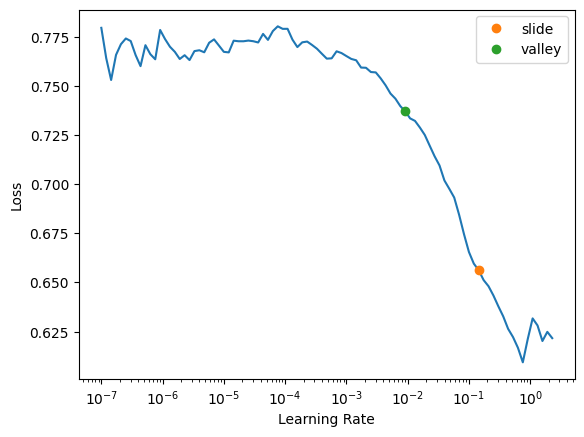

In [45]:
# Criando um modelo de aprendizagem tabular
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

# Encontrando a taxa de aprendizado ideal
learn.lr_find(suggest_funcs=(slide, valley))

In [46]:
# Treinando
learn.fit(8, lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.701071,0.673106,0.590361,00:00
1,0.631003,0.623848,0.590361,00:00
2,0.555465,0.876612,0.759036,00:00
3,0.521314,0.832830,0.734940,00:00
4,0.491552,0.720658,0.807229,00:00
5,0.461591,0.606235,0.807229,00:00
6,0.440293,0.663180,0.771084,00:00
7,0.423622,0.638789,0.795181,00:00


In [50]:
# Obtendo as previsões e os rótulos reais para calcular a acurácia
val_preds, val_targets = learn.get_preds()

val_preds_classes = val_preds.argmax(dim=1).numpy()
val_targets_classes = val_targets.numpy()

# Obtendo os PassengerId para identificar as linhas
passenger_ids = train_df.iloc[splits[1]].PassengerId.values

# Criando uma lista com as previsões, os valores reais e outras informações
predictions_list = []
for i in range(len(val_preds_classes)):
    prediction_info = {
        'PassengerId': passenger_ids[i],
        'Prediction': val_preds_classes[i],
        'Actual': val_targets_classes[i]
    }
    predictions_list.append(prediction_info)

# Exibindo a lista de previsões e valores reais
for prediction_info in predictions_list:
    print(f"PassengerId: {prediction_info['PassengerId']:3.0f}, "
          f"Prediction: {prediction_info['Prediction']}, "
          f"Actual: {prediction_info['Actual'][0]}")

# Contando o número de previsões corretas
num_correct_predictions = sum(1 for prediction_info in predictions_list if prediction_info['Prediction'] == prediction_info['Actual'])

# Calculando a porcentagem de acertos
accuracy_percentage = (num_correct_predictions / len(predictions_list)) * 100

# Exibindo a porcentagem de acertos
print(f"\nPorcentagem de acertos: {accuracy_percentage:.2f}%")

PassengerId:  73, Prediction: 0, Actual: 0
PassengerId: 106, Prediction: 0, Actual: 0
PassengerId: 191, Prediction: 1, Actual: 1
PassengerId:  43, Prediction: 0, Actual: 0
PassengerId: 113, Prediction: 0, Actual: 0
PassengerId:  30, Prediction: 0, Actual: 0
PassengerId: 375, Prediction: 0, Actual: 0
PassengerId: 133, Prediction: 0, Actual: 0
PassengerId: 389, Prediction: 0, Actual: 0
PassengerId: 146, Prediction: 0, Actual: 0
PassengerId: 309, Prediction: 0, Actual: 0
PassengerId: 363, Prediction: 1, Actual: 0
PassengerId: 117, Prediction: 0, Actual: 0
PassengerId:  23, Prediction: 1, Actual: 1
PassengerId: 202, Prediction: 0, Actual: 0
PassengerId: 103, Prediction: 0, Actual: 0
PassengerId: 310, Prediction: 1, Actual: 1
PassengerId: 118, Prediction: 0, Actual: 0
PassengerId: 186, Prediction: 0, Actual: 0
PassengerId: 303, Prediction: 1, Actual: 0
PassengerId:  40, Prediction: 0, Actual: 1
PassengerId: 371, Prediction: 0, Actual: 1
PassengerId: 384, Prediction: 1, Actual: 1
PassengerId

## Exportar modelo para o Hugging Face

In [48]:
learn.export('model.pkl')

## Link do Hugging Face

https://huggingface.co/spaces/luisgaboardi/TitanicSurvivors